84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


<ipython-input-1-d6c895e75825>:65: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

<ipython-input-1-d6c895e75825>:65: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step - accuracy: 0.7194 - loss: 0.5255 - val_accuracy: 0.7854 - val_loss: 0.4598
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - accuracy: 0.9170 - loss: 0.2165 - val_accuracy: 0.8558 - val_loss: 0.3487
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.9832 - loss: 0.0694 - val_accuracy: 0.7402 - val_loss: 0.9029
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8943 - loss: 0.3197
CNN Test Loss: 0.561658501625061, Test Accuracy: 0.8307999968528748
Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 121s 190ms/step - accuracy: 0.7306 - loss: 0.5210 - val_accuracy: 0.8218 - val_loss: 0.3614
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 189ms/step - accuracy: 0.8832 - loss: 0.2903 - val_accuracy: 0.8304 - val_loss: 0.3948
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 189ms/step - accuracy: 0.9137 - loss: 0.2199 - val_accuracy: 0.8418 - val_loss: 0.4302
782/782 ━━━━━━━━━━━━━━━━━━━━ 49s 63ms/step - accuracy: 0.8475 - loss: 0.3679
RNN Test L

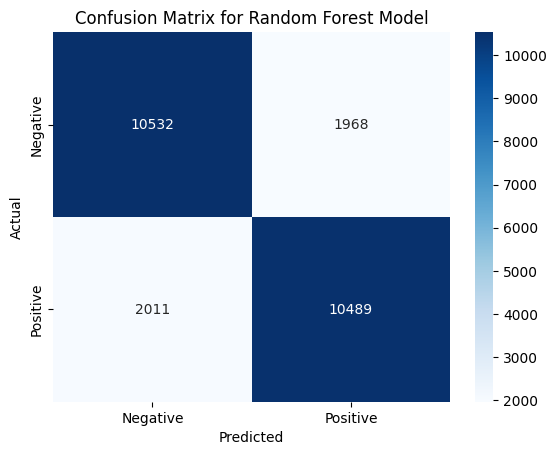

In [ ]:
import os
import shutil
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
import seaborn as sns

# Get the current working directory
current_folder = os.getcwd()

# Download the dataset
dataset = tf.keras.utils.get_file(
    fname="aclImdb.tar.gz",
    origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir=current_folder,
    extract=True
)
dataset_path = os.path.dirname(dataset)

# Check the dataset
dataset_dir = os.path.join(dataset_path, 'aclImdb')

# Load the dataset function
def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}
    for file_name in os.listdir(directory):
        if file_name == 'pos':
            positive_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(positive_dir):
                text = os.path.join(positive_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(1)
        elif file_name == 'neg':
            negative_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(negative_dir):
                text = os.path.join(negative_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(0)

    return pd.DataFrame.from_dict(data)

# Load the dataset
train_dir = os.path.join(dataset_dir, 'train')
train_df = load_dataset(train_dir)
test_dir = os.path.join(dataset_dir, 'test')
test_df = load_dataset(test_dir)

# Clean the text data
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    return re.sub(pattern, '', text)

train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning)
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)

# Split the dataset
X_train = train_df['Cleaned_sentence']
y_train = train_df['sentiment']
X_test = test_df['Cleaned_sentence']
y_test = test_df['sentiment']

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Visualizing Sentiment Counts
sentiment_counts = train_df['sentiment'].value_counts()
fig = px.bar(x={0: 'Negative', 1: 'Positive'},
             y=sentiment_counts.values,
             color=sentiment_counts.index,
             color_discrete_sequence=px.colors.qualitative.Dark24,
             title='<b>Sentiment Counts</b>')

fig.update_layout(title='Sentiment Counts',
                  xaxis_title='Sentiment',
                  yaxis_title='Counts',
                  template='plotly_dark')

# Show the bar chart
fig.show()
pyo.plot(fig, filename='Sentiment_Counts.html', auto_open=True)

# Define and train a CNN model
def create_cnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()
cnn_history = cnn_model.fit(X_train_pad, y_train, epochs=3, batch_size=32, validation_split=0.2)

# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_pad, y_test)
print(f'CNN Test Loss: {cnn_loss}, Test Accuracy: {cnn_accuracy}')

# Define and train an RNN model
def create_rnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

rnn_model = create_rnn_model()
rnn_history = rnn_model.fit(X_train_pad, y_train, epochs=3, batch_size=32, validation_split=0.2)

# Evaluate the RNN model
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test_pad, y_test)
print(f'RNN Test Loss: {rnn_loss}, Test Accuracy: {rnn_accuracy}')

# Train a Random Forest model
# Using Bag-of-Words representation for Random Forest
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=5000)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_bow, y_train)

# Evaluate the Random Forest model
y_pred = rf_model.predict(X_test_bow)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()


<ipython-input-2-fe9871293a27>:65: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.

<ipython-input-2-fe9871293a27>:65: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.7144 - loss: 0.5619 - val_accuracy: 0.8042 - val_loss: 0.7297
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 23s 37ms/step - accuracy: 0.8917 - loss: 0.3348 - val_accuracy: 0.8474 - val_loss: 0.5849
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.9377 - loss: 0.1839 - val_accuracy: 0.7934 - val_loss: 0.6135
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.8742 - loss: 0.2951
CNN Test Loss: 0.412066251039505, Test Accuracy: 0.8442800045013428
Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 196ms/step - accuracy: 0.7484 - loss: 0.5071 - val_accuracy: 0.7896 - val_loss: 0.4841
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 140s 192ms/step - accuracy: 0.8745 - loss: 0.3027 - val_accuracy: 0.7576 - val_loss: 0.5296
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 141s 190ms/step - accuracy: 0.9145 - loss: 0.2251 - val_accuracy: 0.7014 - val_loss: 0.7547
782/782 ━━━━━━━━━━━━━━━━━━━━ 48s 61ms/step - accuracy: 0.8979 - loss: 0.2519
RNN Test 

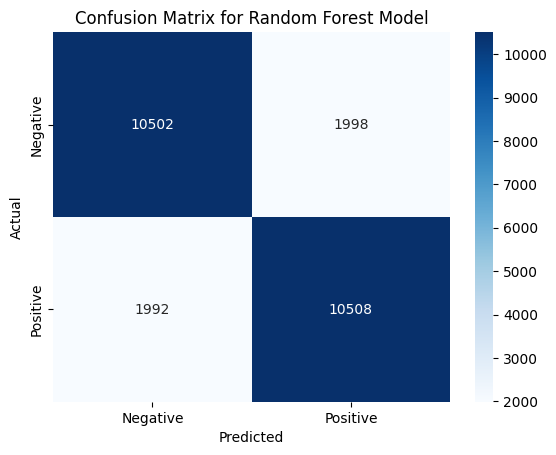

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
{'CNN': 'Positive', 'RNN': 'Positive', 'Random Forest': 'Positive'}


In [ ]:
import os
import shutil
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten
import seaborn as sns

# Get the current working directory
current_folder = os.getcwd()

# Download the dataset
dataset = tf.keras.utils.get_file(
    fname="aclImdb.tar.gz",
    origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir=current_folder,
    extract=True
)
dataset_path = os.path.dirname(dataset)

# Check the dataset
dataset_dir = os.path.join(dataset_path, 'aclImdb')

# Load the dataset function
def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}
    for file_name in os.listdir(directory):
        if file_name == 'pos':
            positive_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(positive_dir):
                text = os.path.join(positive_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(1)
        elif file_name == 'neg':
            negative_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(negative_dir):
                text = os.path.join(negative_dir, text_file)
                with open(text, "r", encoding="utf-8") as f:
                    data["sentence"].append(f.read())
                    data["sentiment"].append(0)

    return pd.DataFrame.from_dict(data)

# Load the dataset
train_dir = os.path.join(dataset_dir, 'train')
train_df = load_dataset(train_dir)
test_dir = os.path.join(dataset_dir, 'test')
test_df = load_dataset(test_dir)

# Clean the text data
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    return re.sub(pattern, '', text)

train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning)
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning)

# Split the dataset
X_train = train_df['Cleaned_sentence']
y_train = train_df['sentiment']
X_test = test_df['Cleaned_sentence']
y_test = test_df['sentiment']

# Tokenization and padding
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_len = 100
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Visualizing Sentiment Counts
sentiment_counts = train_df['sentiment'].value_counts()
fig = px.bar(x={0: 'Negative', 1: 'Positive'},
             y=sentiment_counts.values,
             color=sentiment_counts.index,
             color_discrete_sequence=px.colors.qualitative.Dark24,
             title='<b>Sentiment Counts</b>')

fig.update_layout(title='Sentiment Counts',
                  xaxis_title='Sentiment',
                  yaxis_title='Counts',
                  template='plotly_dark')

# Show the bar chart
fig.show()
pyo.plot(fig, filename='Sentiment_Counts.html', auto_open=True)

# Define and train a CNN model
def create_cnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))
    model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()
cnn_history = cnn_model.fit(X_train_pad, y_train, epochs=3, batch_size=32, validation_split=0.2)

# Evaluate the CNN model
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_pad, y_test)
print(f'CNN Test Loss: {cnn_loss}, Test Accuracy: {cnn_accuracy}')

# Define and train an RNN model
def create_rnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=5000, output_dim=128, input_length=max_len))
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

rnn_model = create_rnn_model()
rnn_history = rnn_model.fit(X_train_pad, y_train, epochs=3, batch_size=32, validation_split=0.2)

# Evaluate the RNN model
rnn_loss, rnn_accuracy = rnn_model.evaluate(X_test_pad, y_test)
print(f'RNN Test Loss: {rnn_loss}, Test Accuracy: {rnn_accuracy}')

# Train a Random Forest model
# Using Bag-of-Words representation for Random Forest
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=5000)
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_bow, y_train)

# Evaluate the Random Forest model
y_pred = rf_model.predict(X_test_bow)
print(classification_report(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# Function to predict sentiment for a new review
def predict_sentiment(review):
    cleaned_review = text_cleaning(review)  # Clean the review text
    review_seq = tokenizer.texts_to_sequences([cleaned_review])
    review_pad = pad_sequences(review_seq, maxlen=max_len)

    cnn_prediction = cnn_model.predict(review_pad)
    rnn_prediction = rnn_model.predict(review_pad)

    # For Random Forest, transform the review using CountVectorizer
    review_bow = vectorizer.transform([cleaned_review])
    rf_prediction = rf_model.predict(review_bow)

    # Interpret predictions
    predictions = {
        'CNN': 'Positive' if cnn_prediction[0] > 0.5 else 'Negative',
        'RNN': 'Positive' if rnn_prediction[0] > 0.5 else 'Negative',
        'Random Forest': 'Positive' if rf_prediction[0] == 1 else 'Negative',
    }

    return predictions

# Example usage
new_review = "The movie was fantastic! I really enjoyed it."
predicted_sentiments = predict_sentiment(new_review)
print(predicted_sentiments)


In [ ]:
# Example usage
new_review = "The movie was worst! I am not enjoyed it."
predicted_sentiments = predict_sentiment(new_review)
print(predicted_sentiments)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
{'CNN': 'Negative', 'RNN': 'Negative', 'Random Forest': 'Negative'}


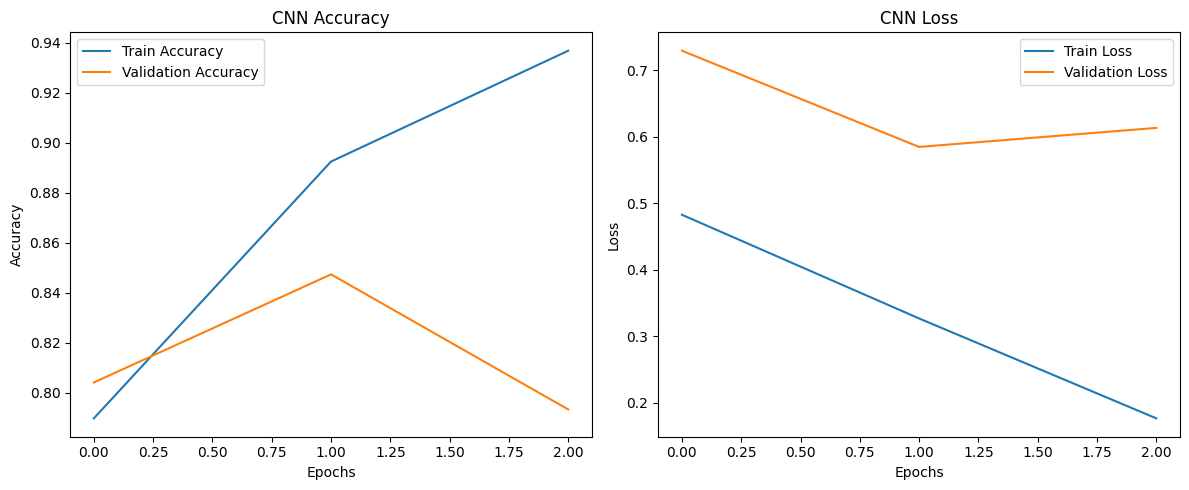

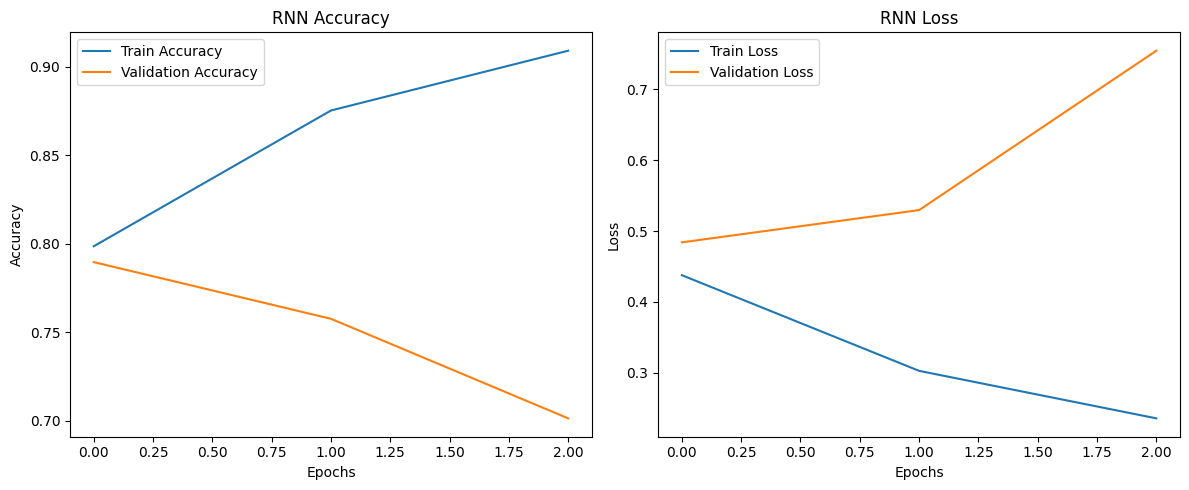

In [ ]:
# Plot training & validation accuracy for CNN
plt.figure(figsize=(12, 5))

# Plot CNN accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot CNN loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Plot training & validation accuracy for RNN
plt.figure(figsize=(12, 5))

# Plot RNN accuracy
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot RNN loss
plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='Train Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('RNN Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


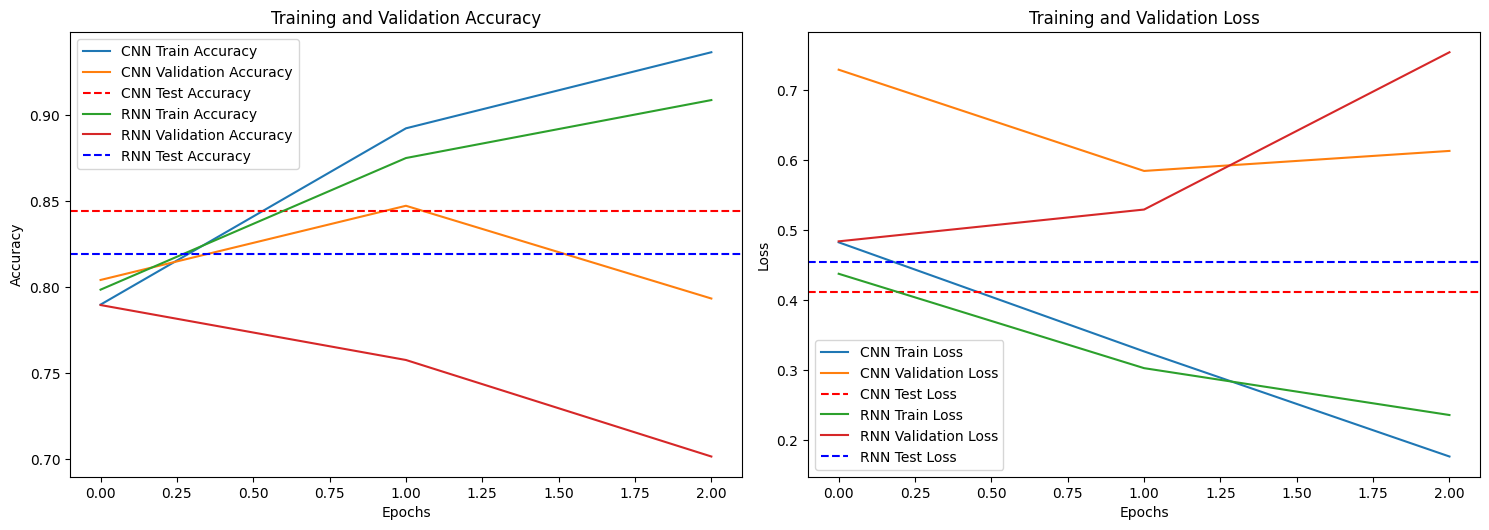

In [ ]:
# Function to plot training and testing accuracy and loss
def plot_model_performance(cnn_history, rnn_history, cnn_loss, rnn_loss, cnn_accuracy, rnn_accuracy):
    plt.figure(figsize=(15, 10))

    # Accuracy Plot
    plt.subplot(2, 2, 1)
    plt.plot(cnn_history.history['accuracy'], label='CNN Train Accuracy')
    plt.plot(cnn_history.history['val_accuracy'], label='CNN Validation Accuracy')
    plt.axhline(y=cnn_accuracy, color='r', linestyle='--', label='CNN Test Accuracy')
    plt.plot(rnn_history.history['accuracy'], label='RNN Train Accuracy')
    plt.plot(rnn_history.history['val_accuracy'], label='RNN Validation Accuracy')
    plt.axhline(y=rnn_accuracy, color='b', linestyle='--', label='RNN Test Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(2, 2, 2)
    plt.plot(cnn_history.history['loss'], label='CNN Train Loss')
    plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
    plt.axhline(y=cnn_loss, color='r', linestyle='--', label='CNN Test Loss')
    plt.plot(rnn_history.history['loss'], label='RNN Train Loss')
    plt.plot(rnn_history.history['val_loss'], label='RNN Validation Loss')
    plt.axhline(y=rnn_loss, color='b', linestyle='--', label='RNN Test Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function after evaluating models
plot_model_performance(cnn_history, rnn_history, cnn_loss, rnn_loss, cnn_accuracy, rnn_accuracy)


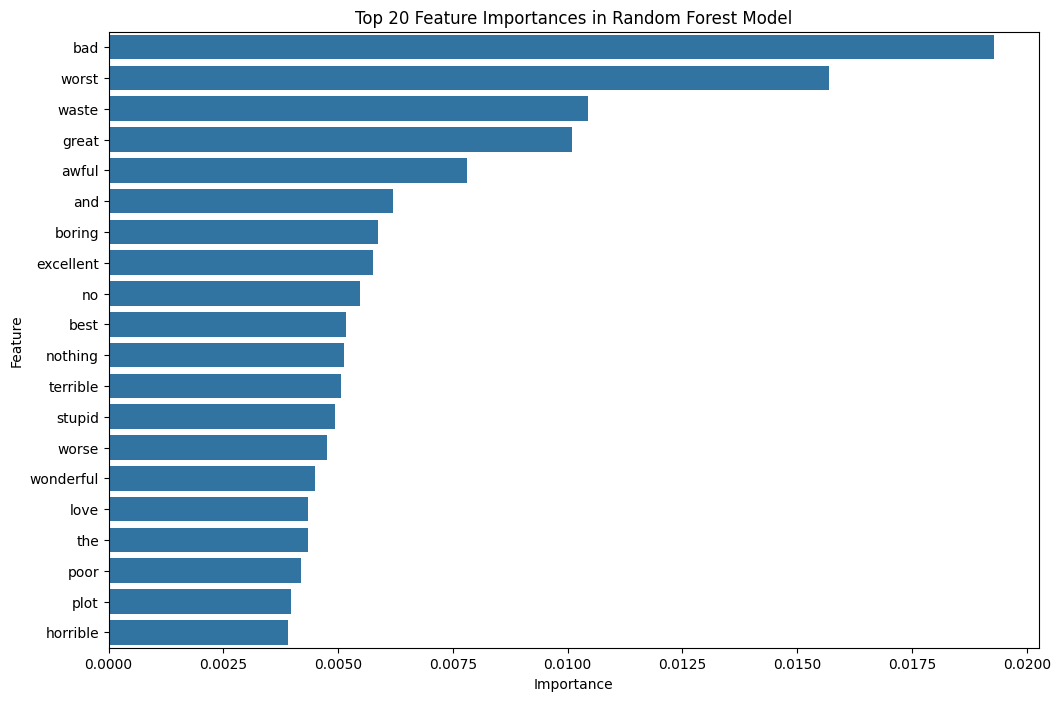

In [ ]:
# Get feature importances from the Random Forest model
importances = rf_model.feature_importances_
features = vectorizer.get_feature_names_out()

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the top 20 feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


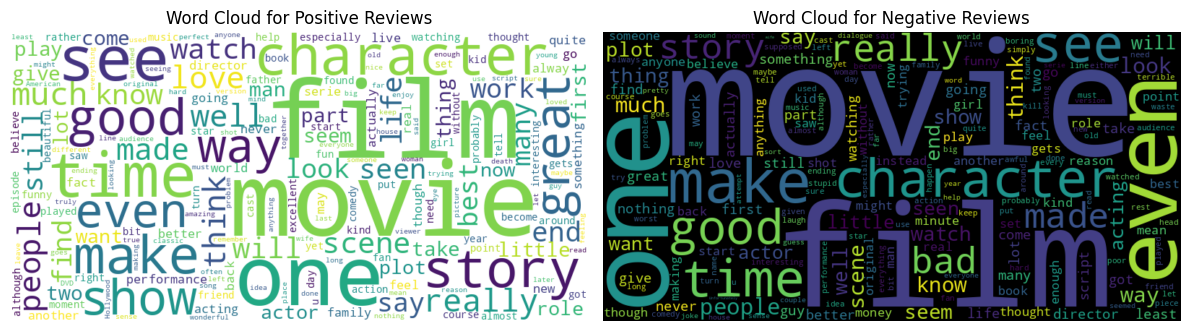

In [ ]:
# Create a word cloud for positive reviews
positive_reviews = train_df[train_df['sentiment'] == 1]['Cleaned_sentence']
positive_text = ' '.join(positive_reviews)

# Create a word cloud for negative reviews
negative_reviews = train_df[train_df['sentiment'] == 0]['Cleaned_sentence']
negative_text = ' '.join(negative_reviews)

# Plotting the word clouds
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')

plt.subplot(1, 2, 2)
wordcloud_negative = WordCloud(width=800, height=400, background_color='black').generate(negative_text)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')

plt.tight_layout()
plt.show()


Random Forest - Train Accuracy: 1.0000, Test Accuracy: 0.4700
Linear SVM - Train Accuracy: 0.5375, Test Accuracy: 0.4900
Polynomial SVM - Train Accuracy: 0.8812, Test Accuracy: 0.5400
RBF SVM - Train Accuracy: 0.8113, Test Accuracy: 0.5200
Gradient Boosting - Train Accuracy: 0.9137, Test Accuracy: 0.5500


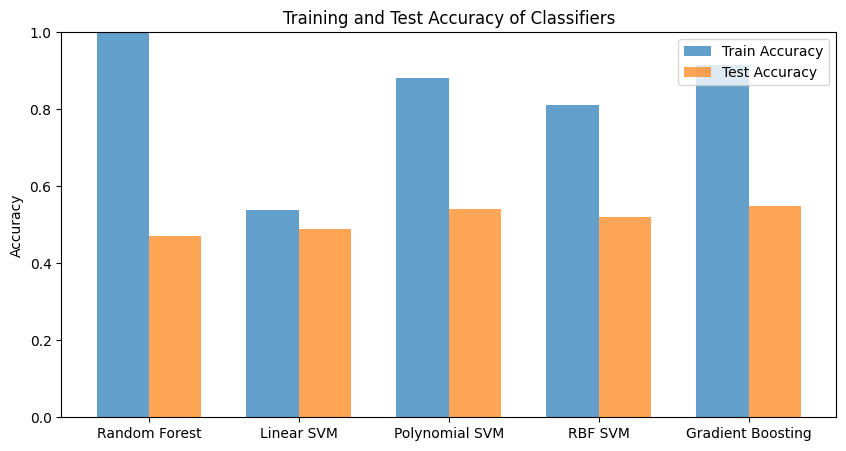

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Sample Data Generation (Replace with your actual dataset)
num_samples = 1000
num_features = 20
num_classes = 2

X = np.random.rand(num_samples, num_features)  # Sample features
y = np.random.randint(0, num_classes, num_samples)  # Sample labels

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Linear SVM': SVC(kernel='linear', random_state=42),
    'Polynomial SVM': SVC(kernel='poly', degree=3, random_state=42),
    'RBF SVM': SVC(kernel='rbf', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

results = {}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    # Calculate accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    results[name] = (train_acc, test_acc)

    # Print results
    print(f"{name} - Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

# Visualization of accuracy results
plt.figure(figsize=(10, 5))
train_acc = [result[0] for result in results.values()]
test_acc = [result[1] for result in results.values()]
labels = list(results.keys())

# Bar plot for train and test accuracy
x = np.arange(len(labels))
width = 0.35  # width of the bars

plt.bar(x - width/2, train_acc, width, label='Train Accuracy', alpha=0.7)
plt.bar(x + width/2, test_acc, width, label='Test Accuracy', alpha=0.7)

plt.xticks(x, labels)
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy of Classifiers')
plt.legend()
plt.ylim(0, 1)
plt.show()
